<a href="https://colab.research.google.com/github/geraldHoff/570_Gaussian_Process/blob/main/Gaussian_Process_For_MSP_of_Sustainable_Aviation_Fue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Cell 1: upload and read the current Excel file (Ethanol_price in USD/L) ===
from google.colab import files
import io
import pandas as pd
import numpy as np

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print("Uploaded file:", file_name)

df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print("Dataset columns:")
print(df.columns.tolist())

print("\nFirst rows:")
display(df.head())


Saving datos_MESP_next (68).xlsx to datos_MESP_next (68).xlsx
Uploaded file: datos_MESP_next (68).xlsx
Dataset columns:
['run', 'SAF_MSPSmall', 'Ethanol_price', 'Diesel_local_price', 'Electricity_rate', 'Price_Natural_Gas', 'Gasoline_local_price', 'Hydrogen_price', 'Loan_interest_rate', 'Clean_fuels_tax_credit']

First rows:


,run,SAF_MSPSmall,Ethanol_price,Diesel_local_price,Electricity_rate,Price_Natural_Gas,Gasoline_local_price,Hydrogen_price,Loan_interest_rate,Clean_fuels_tax_credit
0,1,2.030,0.852407,1.150,0.2150,5.75,1.150,1460.0,0.0800,0.750
1,2,1.420,0.524862,0.725,0.3080,7.88,0.725,1730.0,0.0450,1.130
2,3,2.630,1.176006,1.580,0.1230,3.63,1.580,1180.0,0.1150,0.375
3,4,2.570,1.010260,0.938,0.2610,4.69,0.513,1050.0,0.1320,1.310
4,5,0.684,0.362273,1.790,0.0763,8.94,1.360,1590.0,0.0625,0.563


Fitted kernel:
1.24**2 * RBF(length_scale=[2.09, 2.71, 12.7, 19.6, 3.08, 9.73e+04, 2.75, 1.75])

Best observed SAF_MSPSmall (best_MESP): 0.3180
Training R2 (full data): 1.0000
Training RMSE (full data): 0.0000


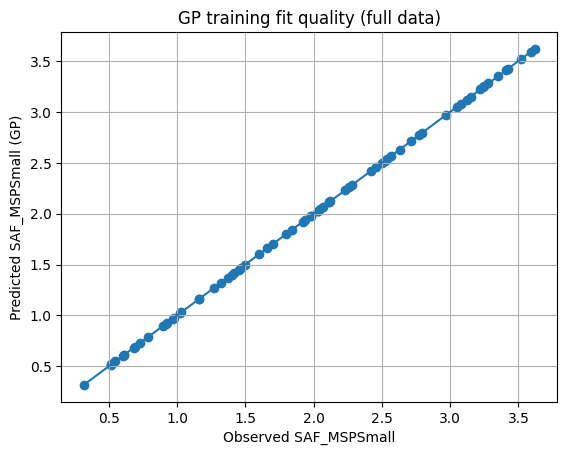

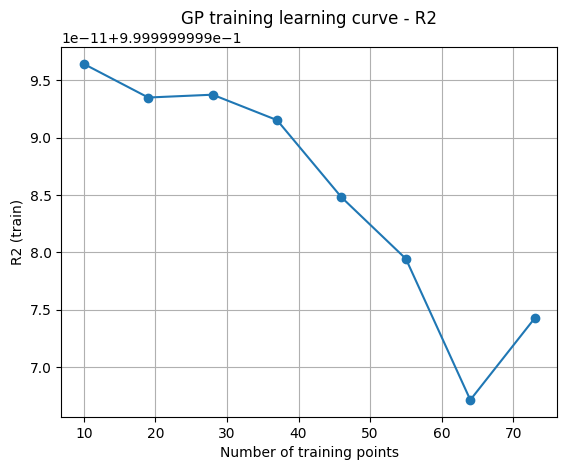

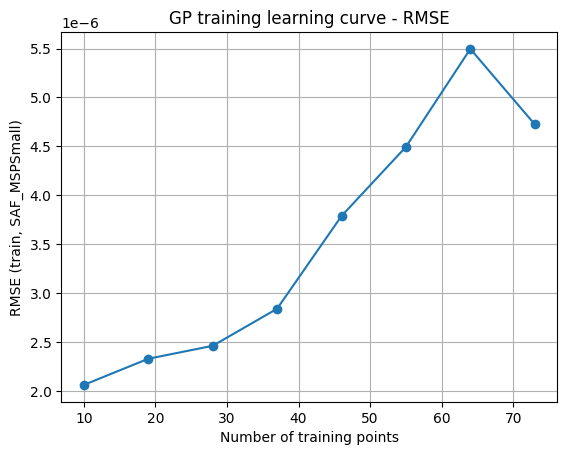

In [ ]:
# === Cell 2: prepare data, train GP, evaluate quality, and plot training learning curves ===

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Name of the target column
target_col = "SAF_MSPSmall"

# Input columns (all in correct physical units, e.g., Ethanol_price in USD/L)
feature_cols = [
    "Ethanol_price",
    "Diesel_local_price",
    "Electricity_rate",
    "Price_Natural_Gas",
    "Gasoline_local_price",
    "Hydrogen_price",
    "Loan_interest_rate",
    "Clean_fuels_tax_credit",
]

# Data matrices
X = df[feature_cols].values
y = df[target_col].values

# Scaling
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# GP kernel (without explicit noise)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(X.shape[1]))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,          # small numeric noise
    normalize_y=False,
    n_restarts_optimizer=5,
    random_state=0,
)

# ---- Fit GP on the full (scaled) dataset ----
gp.fit(X_scaled, y_scaled)

print("Fitted kernel:")
print(gp.kernel_)

# ----- Training quality metrics on full data -----

# Prediction on the same points
y_pred_scaled = gp.predict(X_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

r2_train_full = r2_score(y, y_pred)
rmse_train_full = np.sqrt(mean_squared_error(y, y_pred))
best_MESP = float(np.nanmin(y))

print(f"\nBest observed SAF_MSPSmall (best_MESP): {best_MESP:.4f}")
print(f"Training R2 (full data): {r2_train_full:.4f}")
print(f"Training RMSE (full data): {rmse_train_full:.4f}")

# Scatter plot observed vs predicted
plt.figure()
plt.scatter(y, y_pred)
plt.xlabel("Observed SAF_MSPSmall")
plt.ylabel("Predicted SAF_MSPSmall (GP)")
plt.title("GP training fit quality (full data)")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.grid(True)
plt.show()

# =========================================================
#        TRAINING LEARNING CURVES: R2 AND RMSE
# =========================================================

# We will compute R2 and RMSE on the *same* training points
# while increasing the number of training samples.

n_samples = X_scaled.shape[0]
rng = np.random.RandomState(0)
indices = rng.permutation(n_samples)

X_shuffled = X_scaled[indices]
y_shuffled = y[indices]
y_scaled_shuffled = y_scaled[indices]

# Define training set sizes for the learning curves
min_points = min(10, n_samples)  # at least 10 points if possible
train_sizes = np.linspace(min_points, n_samples, 8, dtype=int)
train_sizes = np.unique(train_sizes)  # ensure unique, sorted sizes

r2_train_list = []
rmse_train_list = []

# Use the fitted kernel (hyperparameters fixed from full-data training)
base_kernel = gp.kernel_

for m in train_sizes:
    # Subset of the training data
    X_sub = X_shuffled[:m]
    y_sub_scaled = y_scaled_shuffled[:m]
    y_sub = y_shuffled[:m]

    # New GP with fixed kernel hyperparameters (no re-optimization)
    gp_lc = GaussianProcessRegressor(
        kernel=base_kernel,
        alpha=1e-6,
        optimizer=None,      # do not re-optimize hyperparameters
        normalize_y=False,
        random_state=0,
    )

    gp_lc.fit(X_sub, y_sub_scaled)

    # Predictions on the same training subset
    y_sub_pred_scaled = gp_lc.predict(X_sub)
    y_sub_pred = y_scaler.inverse_transform(
        y_sub_pred_scaled.reshape(-1, 1)
    ).ravel()

    r2_train = r2_score(y_sub, y_sub_pred)
    rmse_train = np.sqrt(mean_squared_error(y_sub, y_sub_pred))

    r2_train_list.append(r2_train)
    rmse_train_list.append(rmse_train)

# ---- Plot learning curve for R2 (training only) ----
plt.figure()
plt.plot(train_sizes, r2_train_list, marker="o")
plt.xlabel("Number of training points")
plt.ylabel("R2 (train)")
plt.title("GP training learning curve - R2")
plt.grid(True)
plt.show()

# ---- Plot learning curve for RMSE (training only) ----
plt.figure()
plt.plot(train_sizes, rmse_train_list, marker="o")
plt.xlabel("Number of training points")
plt.ylabel("RMSE (train, SAF_MSPSmall)")
plt.title("GP training learning curve - RMSE")
plt.grid(True)
plt.show()


In [ ]:
# === Cell 3: acquisition function + avoid duplicate points ===

# Search bounds (adjust according to your case, all in physical units)
bounds = {
    "Ethanol_price": (0.20, 1.50),           # USD/L
    "Diesel_local_price": (0.30, 2.00),
    "Gasoline_local_price": (0.30, 2.00),
    "Electricity_rate": (0.03, 0.40),        # USD/kWh (example)
    "Price_Natural_Gas": (1.50, 10.0),       # USD/MMBtu (example)
    "Hydrogen_price": (400, 2000),           # USD/kg (example)
    "Loan_interest_rate": (0.01, 0.15),      # fraction
    "Clean_fuels_tax_credit": (0.00, 1.50),  # USD/gal equivalent (example)
}

print("Search bounds used:")
for k, (a, b) in bounds.items():
    print(f"{k}: {a} → {b}")

# Generate random candidates within the bounds
n_candidates = 5000
rng = np.random.RandomState(0)

cand_matrix = np.column_stack([
    rng.uniform(bounds[col][0], bounds[col][1], n_candidates)
    for col in feature_cols
])

cand_scaled = x_scaler.transform(cand_matrix)

# GP prediction for candidates
mean_cand, std_cand = gp.predict(cand_scaled, return_std=True)
var_cand = std_cand**2

# Maximum standard deviation (global measure of uncertainty)
max_std = float(np.max(std_cand))
print(f"\nMaximum standard deviation (max_std) among candidates: {max_std:.4f}")

# ------- Anti-duplicate filter -------

def is_duplicate(x_next, df, feature_cols, tol=1e-6):
    """Returns True if x_next already exists (or almost) in the dataset."""
    X_existing = df[feature_cols].values
    diffs = np.abs(X_existing - x_next)
    return np.any(np.all(diffs <= tol, axis=1))

# Sort candidates by descending variance
order = np.argsort(-var_cand)

x_next = None
best_idx = None

for idx in order:
    cand = cand_matrix[idx]
    if not is_duplicate(cand, df, feature_cols, tol=1e-6):
        x_next = cand
        best_idx = idx
        break

if x_next is None:
    print("\n⚠ All candidates are duplicates. You may need to expand the bounds.")
else:
    print("\nNew suggested point (non-duplicate) for Stella:")
    for col, val in zip(feature_cols, x_next):
        print(f"{col:25s}: {val:.6f}")

Search bounds used:
Ethanol_price: 0.2 → 1.5
Diesel_local_price: 0.3 → 2.0
Gasoline_local_price: 0.3 → 2.0
Electricity_rate: 0.03 → 0.4
Price_Natural_Gas: 1.5 → 10.0
Hydrogen_price: 400 → 2000
Loan_interest_rate: 0.01 → 0.15
Clean_fuels_tax_credit: 0.0 → 1.5

Maximum standard deviation (max_std) among candidates: 0.3663

New suggested point (non-duplicate) for Stella:
Ethanol_price            : 1.261347
Diesel_local_price       : 0.403432
Electricity_rate         : 0.250801
Price_Natural_Gas        : 7.631316
Gasoline_local_price     : 1.863890
Hydrogen_price           : 750.642083
Loan_interest_rate       : 0.142652
Clean_fuels_tax_credit   : 0.030683


In [ ]:
# === Celda 4: añadir la fila sugerida al dataset y guardar Excel ===

if x_next is None:
    print("No se añadió ninguna fila nueva porque todos los candidatos eran duplicados.")
else:
    # Asumimos que los primeros 50 runs son el diseño inicial
    initial_runs = 50
    current_runs = len(df)
    iteration = max(current_runs - initial_runs, 0)

    next_run = int(df["run"].max()) + 1

    new_row = {"run": next_run, target_col: np.nan}
    for col, val in zip(feature_cols, x_next):
        new_row[col] = val

    df_next = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    print(f"\nFila nueva añadida (run = {next_run}, iteración = {iteration}):")
    display(df_next.tail())

    # Guardar dataset actualizado
    updated_data_file = "datos_MESP_next.xlsx"
    df_next.to_excel(updated_data_file, index=False)

    from google.colab import files
    files.download(updated_data_file)


Fila nueva añadida (run = 74, iteración = 23):


,run,SAF_MSPSmall,Ethanol_price,Diesel_local_price,Electricity_rate,Price_Natural_Gas,Gasoline_local_price,Hydrogen_price,Loan_interest_rate,Clean_fuels_tax_credit
69,70,3.59,1.371944,1.051672,0.364890,9.398980,0.396907,523.426229,0.148140,0.138487
70,71,3.28,1.435918,1.865880,0.345458,3.260996,0.356981,1409.033053,0.021214,0.975437
71,72,1.70,0.371217,0.317662,0.193850,6.977514,0.916527,835.735659,0.147455,0.065012
72,73,3.05,1.405560,1.806307,0.123870,4.381557,1.856815,1178.254876,0.143711,1.424732
73,74,NaN,1.261347,0.403432,0.250801,7.631316,1.863890,750.642083,0.142652,0.030683


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Cell 5: record model quality and acquisition into a log ===

import os
import csv

log_file = "gp_progress_log.csv"

# Create file with header if it does not exist
if not os.path.exists(log_file):
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "n_runs", "best_MESP", "max_std", "R2_train", "RMSE_train"])

n_runs = len(df)

# Append row for this iteration
with open(log_file, "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([iteration, n_runs, best_MESP, max_std, r2_train, rmse_train])

# Read log
log_df = pd.read_csv(log_file)
print("GP progress history:")
display(log_df)

from google.colab import files
files.download(log_file)


GP progress history:


,iteration,n_runs,best_MESP,max_std,R2_train,RMSE_train
0,0,50,0.518,0.549851,1.0,0.000004
1,1,51,0.518,0.490373,1.0,0.000005
2,2,52,0.518,0.529582,1.0,0.000005
3,3,53,0.518,0.514647,1.0,0.000004
4,4,54,0.515,0.531774,1.0,0.000004
5,5,55,0.515,0.456007,1.0,0.000005
6,6,56,0.515,0.475933,1.0,0.000005
7,7,57,0.515,0.452661,1.0,0.000005
8,8,58,0.515,0.545375,1.0,0.000005
9,9,59,0.515,0.374108,1.0,0.000005


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

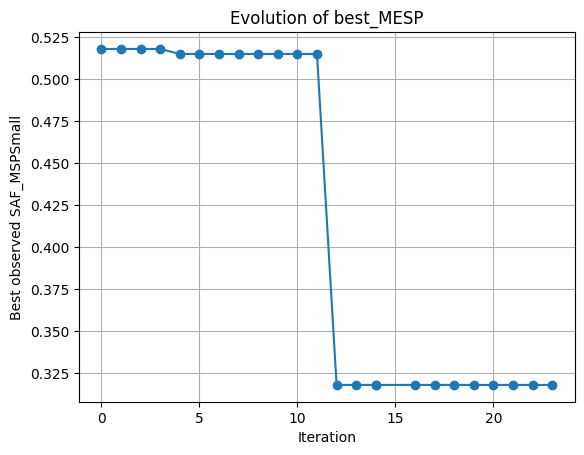

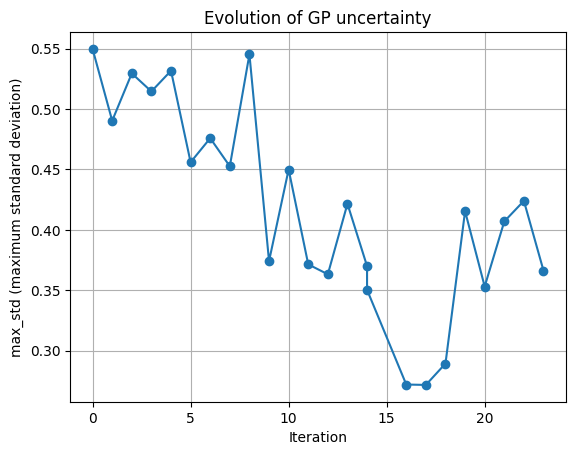

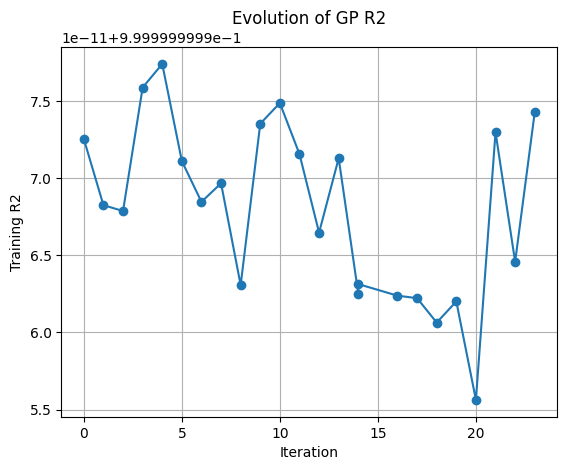

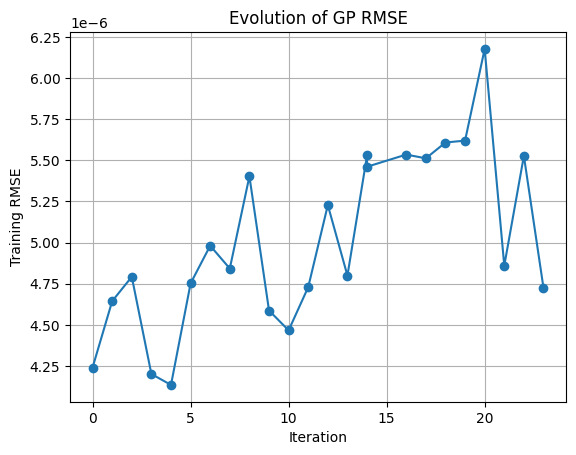

Excel final creado: SAF_GP_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Cell 6: plots of model quality and exploration ===
import matplotlib.pyplot as plt
import pandas as pd

log_df = pd.read_csv("gp_progress_log.csv")

# best_MESP per iteration
plt.figure()
plt.plot(log_df["iteration"], log_df["best_MESP"], marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best observed SAF_MSPSmall")
plt.title("Evolution of best_MESP")
plt.grid(True)
plt.show()

# max_std per iteration
plt.figure()
plt.plot(log_df["iteration"], log_df["max_std"], marker="o")
plt.xlabel("Iteration")
plt.ylabel("max_std (maximum standard deviation)")
plt.title("Evolution of GP uncertainty")
plt.grid(True)
plt.show()

# R2
plt.figure()
plt.plot(log_df["iteration"], log_df["R2_train"], marker="o")
plt.xlabel("Iteration")
plt.ylabel("Training R2")
plt.title("Evolution of GP R2")
plt.grid(True)
plt.show()

# RMSE
plt.figure()
plt.plot(log_df["iteration"], log_df["RMSE_train"], marker="o")
plt.xlabel("Iteration")
plt.ylabel("Training RMSE")
plt.title("Evolution of GP RMSE")
plt.grid(True)
plt.show()

# === Celda 7: crear Excel final con datos + progreso del GP ===

!pip install xlsxwriter

import pandas as pd

# df_next debe ser el dataset con la última fila añadida
# si no está en memoria, puedes leer el Excel final:
# df_next = pd.read_excel("datos_MESP_next.xlsx")

log_df = pd.read_csv("gp_progress_log.csv")

final_excel = "SAF_GP_results.xlsx"

with pd.ExcelWriter(final_excel, engine="xlsxwriter") as writer:
    df_next.to_excel(writer, sheet_name="data", index=False)
    log_df.to_excel(writer, sheet_name="progress", index=False)

print("Excel final creado:", final_excel)

from google.colab import files
files.download(final_excel)


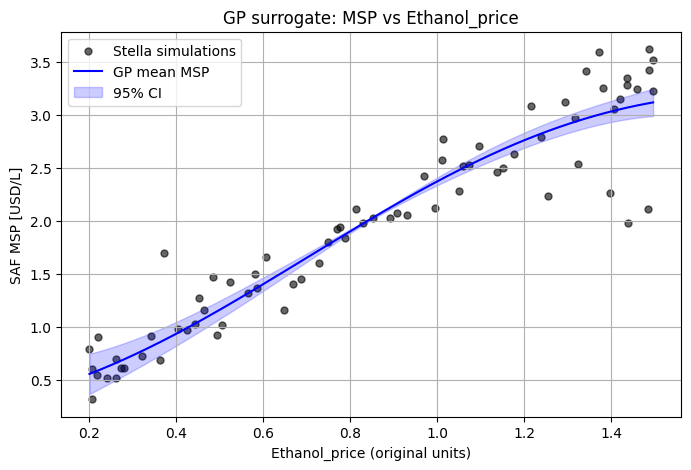

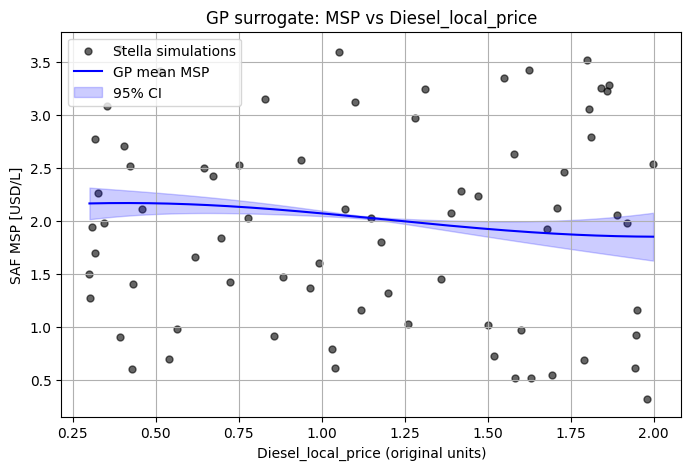

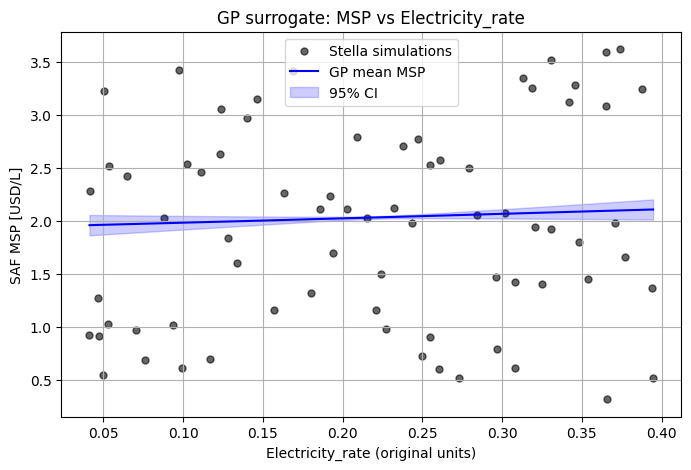

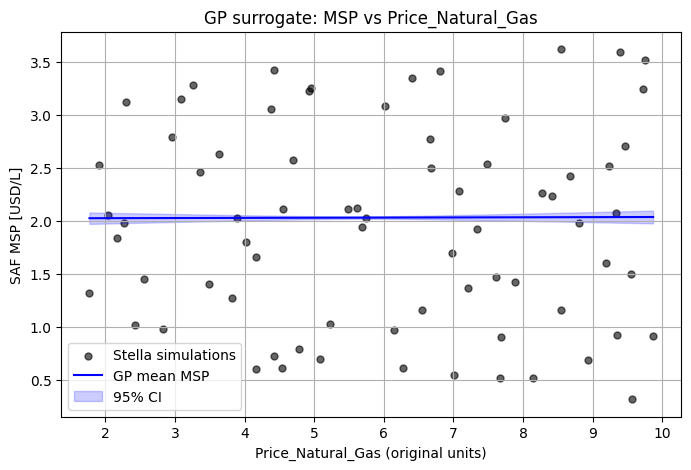

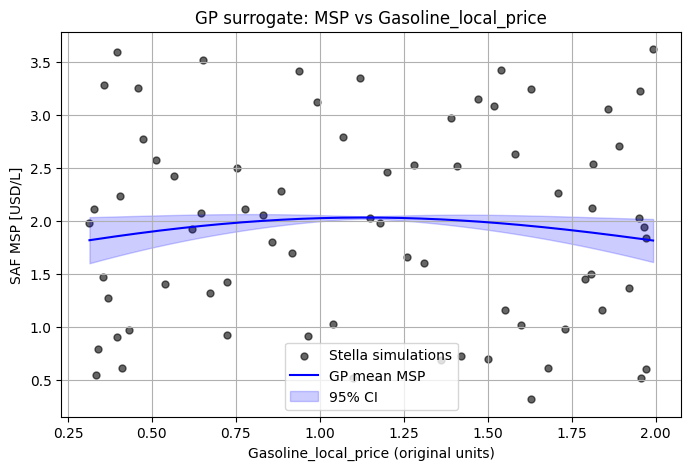

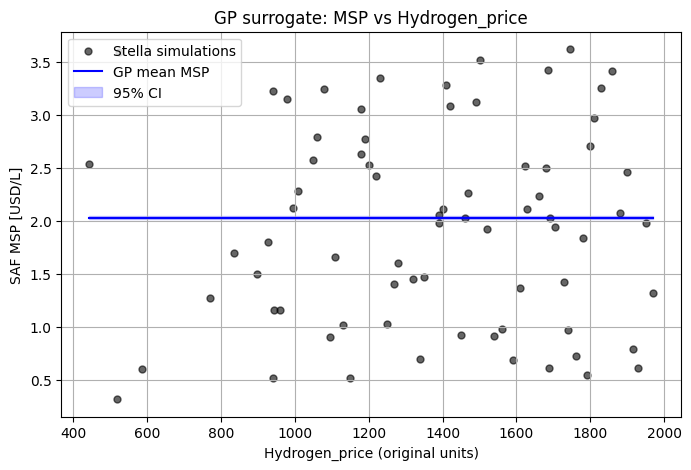

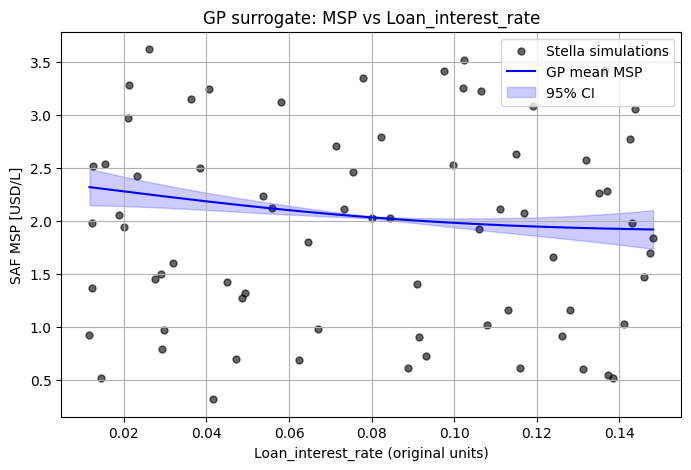

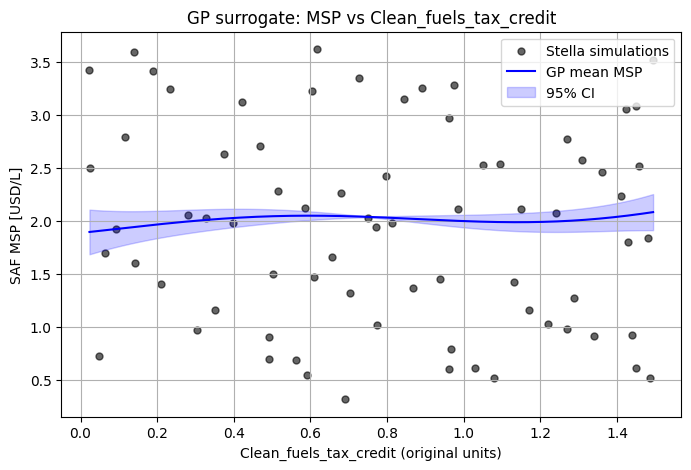

In [ ]:
# === Cell 8: 1D GP curves (MSP vs each input variable) ===
import numpy as np
import matplotlib.pyplot as plt

X_all = df[feature_cols].values        # all inputs in original units
y_all = df[target_col].values          # original MSP
x_mean = X_all.mean(axis=0)           # reference point (mean of each variable)
n_points = 200

def plot_gp_1d(feature_name):
    """Plot 1D GP surrogate: MSP vs a single input variable."""
    # 1. Find index of the feature
    feature_idx = feature_cols.index(feature_name)

    # 2. Build a 1D grid varying ONLY that variable
    feature_min = X_all[:, feature_idx].min()
    feature_max = X_all[:, feature_idx].max()
    x_grid = np.linspace(feature_min, feature_max, n_points)

    # Matrix of points where only that variable changes
    X_plot = np.tile(x_mean, (n_points, 1))
    X_plot[:, feature_idx] = x_grid

    # 3. Scale and predict with the GP
    X_plot_scaled = x_scaler.transform(X_plot)
    mean_scaled, std_scaled = gp.predict(X_plot_scaled, return_std=True)

    # Invert MSP scaling
    y_mean = y_scaler.inverse_transform(mean_scaled.reshape(-1, 1)).ravel()
    y_std = std_scaled * y_scaler.scale_[0]   # re-scale standard deviation

    # 4. Project training data on that variable
    x_train_feat = X_all[:, feature_idx]
    y_train = y_all

    # 5. Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x_train_feat, y_train,
                c='k', s=25, alpha=0.6,
                label="Stella simulations")
    plt.plot(x_grid, y_mean, 'b-', label="GP mean MSP")
    plt.fill_between(x_grid,
                     y_mean - 1.96 * y_std,
                     y_mean + 1.96 * y_std,
                     color='blue', alpha=0.2,
                     label="95% CI")

    plt.xlabel(f"{feature_name} (original units)")
    plt.ylabel("SAF MSP [USD/L]")
    plt.title(f"GP surrogate: MSP vs {feature_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---- Generate one figure for each input variable ----
for feature_name in feature_cols:
    plot_gp_1d(feature_name)
